# Problem Set 1 - Neural Network Implementation

As described in section "3 Neural network implementation" of assignment 1, the goal is to build a Feed-forward Neural Network for classification using different approaches. To validate that your code is working and that the network is actually learning something, you can use the MNIST dataset. Finally, please submit proof of the learning progress as described in the assignment.

## Logistics
Team number: PS1 Group E <br>
Names: ,Kai Foerster <br>
Marticulation numbers: ,214288

## Imports

In [5]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from network_scratch import NeuralNetwork
from network_pytorch import NeuralNetworkTorch
from network_tensorflow import NeuralNetworkTf, TimeBasedLearningRate
import utils
import torchvision as tv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

tf.config.run_functions_eagerly(True)

In [6]:
# Automatically load changes in imported modules
%load_ext autoreload
%autoreload 2

# Explicitly set seed for reproducibility
GLOBAL_RANDOM_STATE = 42

random.seed(GLOBAL_RANDOM_STATE)
np.random.seed(GLOBAL_RANDOM_STATE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## A) Neural Network Classifier from Scratch

### Data


In [ ]:
# Download MNIST dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True, as_frame=False)

# Preprocess dataset
x = (x / 255).astype('float32')
y = tf.keras.utils.to_categorical(y)

# Use only small subset of data for faster training
x = x[:1000]
y = y[:1000]

# Split data into train and validation set
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=GLOBAL_RANDOM_STATE)



### ML Model & Training

In [ ]:
dnn = NeuralNetwork([x_train.shape[1], 2**7, 2**6, 10], learning_rate=1.5, epochs=50)
history = dnn.fit(x_train, y_train, x_val, y_val)

### Evaluation

In [ ]:
'''TODO: plot accuracy on train and validation set over epochs'''

## B) Neural Network Classifier using PyTorch

### Data

In [7]:
# Define data preprocessing steps
transform = tv.transforms.Compose([
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5,), (0.5,))
            ])

# Download MNIST dataset
train_set = tv.datasets.MNIST('data', train=True, download=True, transform=transform)
val_set = tv.datasets.MNIST('data', train=False, download=True, transform=transform)

# Use only small subset of data for faster training
train_set = torch.utils.data.Subset(train_set, range(1000))
val_set = torch.utils.data.Subset(val_set, range(1000))

# Utilize PyTorch DataLoader from simplified & harmonized loading of data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1)


### ML Model & Training

In [8]:
#Copy pasted from network_pytorch

class NeuralNetworkTorch(nn.Module):
    def __init__(self, sizes, epochs=10, learning_rate=0.01, random_state=1):
        super().__init__()

        self.epochs = epochs
        self.learning_rate = learning_rate
        self.random_state = random_state   
        torch.manual_seed(self.random_state)

        # Initializing layers as per the sizes
        self.layers = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.layers.append(nn.Linear(sizes[i], sizes[i + 1]))

        self.activation_func = torch.sigmoid
        self.loss_func = nn.BCEWithLogitsLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        
    def _forward_pass(self, x_train):
        for layer in self.layers[:-1]:
            x_train = self.activation_func(layer(x_train))
        return F.log_softmax(self.layers[-1](x_train), dim=1)

    def _backward_pass(self, y_train, output):
        loss = self.loss_func(output, y_train.float())
        loss.backward()

    def _update_weights(self):
        self.optimizer.step()

    def _flatten(self, x):
        return x.view(x.size(0), -1)       

    def predict(self, x):
        x = self._flatten(x)
        output = self._forward_pass(x)
        return torch.argmax(output, axis=1)

    def fit(self, train_loader, val_loader):
        start_time = time.time()
        history = {'accuracy': [], 'val_accuracy': []} 

        for iteration in range(self.epochs): 
            for x, y in train_loader:
                x = self._flatten(x)
                y = nn.functional.one_hot(y, 10)
                self.optimizer.zero_grad()

                output = self._forward_pass(x) 
                self._backward_pass(y, output)
                self._update_weights()

            train_accuracy, val_accuracy = self._print_learning_progress(start_time, iteration, train_loader, val_loader)
            history['accuracy'].append(train_accuracy)
            history['val_accuracy'].append(val_accuracy)

        return history

    def _print_learning_progress(self, start_time, iteration, train_loader, val_loader):
        train_accuracy = self.compute_accuracy(train_loader)
        val_accuracy = self.compute_accuracy(val_loader)
        print(
            f'Epoch: {iteration + 1}, ' \
            f'Training Time: {time.time() - start_time:.2f}s, ' \
            f'Learning Rate: {self.optimizer.param_groups[0]["lr"]}, ' \
            f'Training Accuracy: {train_accuracy * 100:.2f}%, ' \
            f'Validation Accuracy: {val_accuracy * 100:.2f}%'
            )
        return train_accuracy, val_accuracy

    def compute_accuracy(self, data_loader):
        correct = 0
        for x, y in data_loader:
            pred = self.predict(x)
            correct += torch.sum(torch.eq(pred, y))

        return correct / len(data_loader.dataset)

In [9]:
model = NeuralNetworkTorch(sizes=[784, 2**7, 2**6, 10], learning_rate=1.5, epochs=50, random_state=GLOBAL_RANDOM_STATE)
history_torch = model.fit(train_loader, val_loader)

Epoch: 1, Training Time: 2.21s, Learning Rate: 1.5, Training Accuracy: 22.30%, Validation Accuracy: 19.40%
Epoch: 2, Training Time: 4.52s, Learning Rate: 1.5, Training Accuracy: 56.20%, Validation Accuracy: 52.30%
Epoch: 3, Training Time: 6.54s, Learning Rate: 1.5, Training Accuracy: 62.00%, Validation Accuracy: 56.70%
Epoch: 4, Training Time: 8.67s, Learning Rate: 1.5, Training Accuracy: 59.30%, Validation Accuracy: 52.90%
Epoch: 5, Training Time: 10.77s, Learning Rate: 1.5, Training Accuracy: 59.70%, Validation Accuracy: 52.30%
Epoch: 6, Training Time: 12.75s, Learning Rate: 1.5, Training Accuracy: 65.30%, Validation Accuracy: 55.50%
Epoch: 7, Training Time: 15.23s, Learning Rate: 1.5, Training Accuracy: 75.80%, Validation Accuracy: 68.00%
Epoch: 8, Training Time: 17.85s, Learning Rate: 1.5, Training Accuracy: 66.00%, Validation Accuracy: 56.00%
Epoch: 9, Training Time: 20.71s, Learning Rate: 1.5, Training Accuracy: 64.20%, Validation Accuracy: 55.20%
Epoch: 10, Training Time: 23.96s

### Evaluation

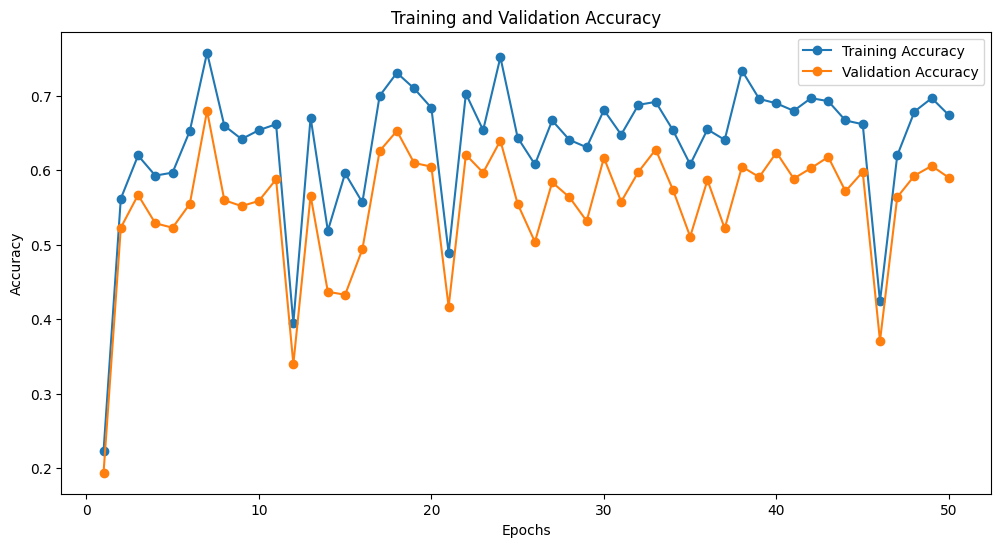

In [10]:
'''TODO: plot accuracy on train and validation set over epochs'''

import matplotlib.pyplot as plt

epochs = range(1, len(history_torch['accuracy']) + 1)

plt.figure(figsize=(12,6))

# Plotting training accuracy
plt.plot(epochs, history_torch['accuracy'], label='Training Accuracy', marker='o')

# Plotting validation accuracy
plt.plot(epochs, history_torch['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## C) Neural Network Classifier using Keras

### Data

In [10]:
# Download MNIST dataset
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

# Preprocess dataset
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

# Use only small subset of data for faster training

x_train = x_train[:1000]
y_train = y_train[:1000]

x_val = x_val[:1000]
y_val = y_val[:1000]


### ML Model & Training

In [26]:
model_tf = NeuralNetworkTf(sizes=[784, 2**7, 2**5, 10])
tb_learning_rate = TimeBasedLearningRate(10)

In [ ]:
history_tf = model_tf.compile_and_fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, learning_rate=tb_learning_rate, batch_size=1)

### Evaluation

In [ ]:
'''TODO: plot accuracy on train and validation set over epochs'''